In [24]:
import pandas as pd
import os
import re
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
import xgboost as xgb
from gpboost import GPBoostClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, make_scorer, classification_report,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
)

In [25]:
def validate_tsv(file_path):
    try:
        df = pd.read_csv(file_path, sep='\t')
        df.columns = df.columns.str.strip()
        print("\n✅ File loaded successfully!")
        return df
    except Exception as e:
        print(f"\n❌ Error loading file: {e}")
        return None

In [26]:
import os
import pandas as pd
import re


def clean_column_name(name: str) -> str:
    name = name.strip()
    name = re.sub(r'[^0-9a-zA-Z]+', '_', name)
    name = re.sub(r'_+', '_', name).strip('_')
    return name


def concat_with_original(df, drop_threshold=10):
    original_file_path = os.path.join(os.getcwd(), 'originaldata.tsv')
    if not os.path.exists(original_file_path):
        raise FileNotFoundError(f"originaldata.tsv not found in {os.getcwd()}")

    # Read the original file
    original_df = pd.read_csv(original_file_path, sep='\t')
    original_df.columns = original_df.columns.str.strip()
    # Concatenate rows; columns matched by name
    merged_df = pd.concat([original_df, df], axis=0, ignore_index=True)

    # Build mapping of original → cleaned names
    name_mapping = {col: clean_column_name(col) for col in merged_df.columns}

    # Apply renaming
    merged_df.rename(columns=name_mapping, inplace=True)

    # Drop numeric columns with sum < drop_threshold
    numeric_cols = merged_df.select_dtypes(include=['number']).columns
    low_sum_cols = [col for col in numeric_cols if merged_df[col].sum() < drop_threshold]

    if low_sum_cols:
        print(f" Dropping columns (sum < {drop_threshold}): {low_sum_cols}")
        merged_df.drop(columns=low_sum_cols, inplace=True)
    else:
        print(f" No numeric columns with sum < {drop_threshold} found.")

    # Save merged file
    merged_file_path = os.path.join(os.getcwd(), 'merged_data.tsv')
    merged_df.to_csv(merged_file_path, sep='\t', index=False)

    print(f"✅ Concatenated file saved: {merged_file_path}")
    print("✅ Column name mapping:")
    for orig, cleaned in name_mapping.items():
        if orig != cleaned:
            print(f"   {orig}  →  {cleaned}")

    return merged_df


In [27]:
def fillmissingvals(df):
    print(df.isnull().sum())
    df = df.fillna(0)
    print(df.isnull().sum())
    return(df)


In [28]:
def dropdate(df):
    if "date" in df.columns:
        df = df.drop(columns=["date"])
        print("Dropped column: date")
    return df


In [29]:

def encodecategory(df):
    df['category'] = pd.get_dummies(df['category'])['Severe'].astype(int)
    print(df['category'].head())
    return(df)
def encodeGender(df):
    df['Gender'] = pd.get_dummies(df['Gender'])['Female'].astype(int)
    print(df['Gender'].head())
    return df
def regiondummies(df):
    region_dummies = pd.get_dummies(df['region'], prefix='region').astype(int)
    region_dummies = region_dummies.drop(region_dummies.columns[0], axis=1)
    df = pd.concat([df, region_dummies], axis=1)
    df = df.drop(['region'], axis=1)
    return(df)
def countrydummies(df):
    country_dummies = pd.get_dummies(df['country'], prefix='country').astype(int)
    country_dummies = country_dummies.drop(country_dummies.columns[0], axis=1)
    df = pd.concat([df , country_dummies], axis=1)
    df = df.drop(['country'], axis=1)
    return df
def cladedummies(df):
    clade_dummies = pd.get_dummies(df ['clade'], prefix='clade').astype(int)
    clade_dummies = clade_dummies.drop(clade_dummies.columns[0], axis = 1)
    df  = pd.concat([df , clade_dummies], axis=1)
    df = df.drop(['clade'], axis=1)
    return df
def pangodummies(df):
    pango_dummies = pd.get_dummies(df ['Nextclade_pango'], prefix='Nextclade_pango').astype(int)
    pango_dummies = pango_dummies.drop(pango_dummies.columns[0], axis = 1)
    df = pd.concat([df , pango_dummies], axis=1)
    df = df.drop(['Nextclade_pango'], axis = 1)
    return df

In [30]:
import re

def clean_for_lightgbm(df):
    clean_cols = {}
    for col in df.columns:
        new_col = re.sub(r'\W+', '_', str(col))   # replace non-alphanumeric with "_"
        new_col = re.sub(r'_+', '_', new_col)     # collapse multiple "_"
        new_col = new_col.strip('_')              # strip leading/trailing "_"
        clean_cols[col] = new_col
    df = df.rename(columns=clean_cols)
    return df

In [31]:
def xydataset(df):
    X = df.drop(columns = ['strain', 'category'])
    y = df['category']
    print(y.head())
    return X,y

def split_dataset(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    return X_train, X_test, y_train, y_test

from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

def normalizeage(X_train, X_test):
    X_train["Patient_age"] = pd.to_numeric(X_train["Patient_age"], errors="coerce")
    X_test["Patient_age"] = pd.to_numeric(X_test["Patient_age"], errors="coerce")

    sns.displot(X_train["Patient_age"].dropna(), kde=True)
    plt.title("Age distribution before normalization")
    plt.show()

    print("Before scaling (Train):", 
          X_train["Patient_age"].min(), 
          X_train["Patient_age"].max(), 
          X_train["Patient_age"].mean(), 
          X_train["Patient_age"].std())

    print("Before scaling (Test):", 
          X_test["Patient_age"].min(), 
          X_test["Patient_age"].max(), 
          X_test["Patient_age"].mean(), 
          X_test["Patient_age"].std())

    scaler = StandardScaler()
    X_train[["Patient_age"]] = scaler.fit_transform(X_train[["Patient_age"]])
    X_test[["Patient_age"]] = scaler.transform(X_test[["Patient_age"]])

    print("After scaling (Train):", 
          X_train["Patient_age"].min(), 
          X_train["Patient_age"].max(), 
          X_train["Patient_age"].mean(), 
          X_train["Patient_age"].std())

    print("After scaling (Test):", 
          X_test["Patient_age"].min(), 
          X_test["Patient_age"].max(), 
          X_test["Patient_age"].mean(), 
          X_test["Patient_age"].std())

    return X_train, X_test

In [32]:
def create_lgb_datasets(X_train, y_train, X_test, y_test):
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test)
    return train_data, valid_data

In [45]:
import gpboost as gpb
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from scipy.stats import randint, uniform

def cvgpboostmixed(X_train_np, y_train_np, group_train_np,
                   X_test_np, group_test_np,
                   n_iter=5, n_splits=5):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    auc_scores = []
    best_params_global = None
    best_auc_global = 0

    for train_index, val_index in kf.split(X_train_np):
        X_train_cv, X_val_cv = X_train_np[train_index], X_train_np[val_index]
        y_train_cv, y_val_cv = y_train_np[train_index], y_train_np[val_index]
        group_train_cv, group_val_cv = group_train_np[train_index], group_train_np[val_index]

        gp_model = gpb.GPModel(group_data=group_train_cv, likelihood="gaussian")

        best_auc = 0
        best_params = None

        for i in range(n_iter):
            params = {
                'objective': 'binary',
                'n_estimators': randint(500, 2100).rvs(),
                'max_depth': randint(10, 41).rvs(),
                'num_leaves': randint(10, 41).rvs(),
                'learning_rate': uniform(0.001, 0.099).rvs(),
                'seed': 42,
                'num_threads': 2
            }

            train_data = gpb.Dataset(data=X_train_cv, label=y_train_cv)

            model_cv = gpb.train(params=params,
                                 train_set=train_data,
                                 gp_model=gp_model,
                                 num_boost_round=params['n_estimators'])

            preds_cv = model_cv.predict(data=X_val_cv,
                                        group_data_pred=group_val_cv,
                                        pred_latent=False)['response_mean']

            auc = roc_auc_score(y_val_cv, preds_cv)

            if auc > best_auc:
                best_auc = auc
                best_params = params

        auc_scores.append(best_auc)

        if best_auc > best_auc_global:
            best_auc_global = best_auc
            best_params_global = best_params

        print(f"Best AUC for fold: {best_auc:.4f} with params {best_params}")

    print("\nMean CV AUC:", np.mean(auc_scores))
    print("Best params overall:", best_params_global)

    # ----- Train final model on full training data with best params -----
    gp_model_final = gpb.GPModel(group_data=group_train_np, likelihood="gaussian")
    train_data_full = gpb.Dataset(data=X_train_np, label=y_train_np)

    final_model = gpb.train(params=best_params_global,
                            train_set=train_data_full,
                            gp_model=gp_model_final,
                            num_boost_round=best_params_global['n_estimators'])

    # ----- Predict on external test set -----
    preds_test = final_model.predict(data=X_test_np,
                                     group_data_pred=group_test_np,
                                     pred_latent=False)['response_mean']

    return final_model, preds_test


In [34]:
def params():
    param_dist = {
    'n_estimators': randint(500, 2100),
    'max_depth': randint(10, 41),
    'num_leaves': randint(10, 51),
    'learning_rate': uniform(0.001, 0.099)  # ~0.001 to 0.1
    }
    return param_dist

def cvfunc():
    cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
    scorer = make_scorer(accuracy_score)
    return cv_strategy,scorer

def modelrandomsearchfit(X_train, y_train):
    param_dist = params()

    cv_strategy, scorer = cvfunc()

    model = LGBMClassifier()

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=50,
        scoring=scorer,
        cv=cv_strategy,
        verbose=2,
        n_jobs=2,
        random_state=42
    )

    random_search.fit(X_train, y_train)
    return random_search
    
    

In [35]:
def ruccurve(y_test, y_prob, model_name="LightGBM", save_path="roc_curve_LightGBM.tiff"):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    print('fpr =', fpr)
    print('tpr =', tpr)
    print('thresholds =', thresholds)
    print(f"AUC = {auc_score:.3f}")

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.3f})", color='darkblue', lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.5)  # Random baseline
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=600, format='tiff')
    plt.show()

In [36]:
def paramsxgcr():
    param_distxgcr = {
    'n_estimators': randint(500, 2100),              # 500 to 2099
    'max_depth': randint(10, 41),                    # 10 to 40
    'learning_rate': uniform(0.001, 0.099),          # 0.001 to 0.1
    'reg_lambda': uniform(0.0, 3.0),                 # 0 to 3
    'gamma': uniform(0.0, 2.0)                       # 0 to 2
    }
    return param_distxgcr

In [37]:
def modelrandomsearchfitxbcr(X_train, y_train):
    param_distxgcr = paramsxgcr()

    cv_strategy, scorer = cvfunc()

    modelXGB = XGBClassifier()

    random_searchXGB = RandomizedSearchCV(
        estimator=modelXGB,
        param_distributions=param_distxgcr,
        n_iter=50,
        scoring=scorer,
        cv=cv_strategy,
        verbose=2,
        n_jobs=2,
        random_state=42
    )

    random_searchXGB.fit(X_train, y_train)
    return random_searchXGB

In [38]:
def ruccurveXGB(y_test, y_prob, model_name="XGBoost", save_path="roc_curve_XGBoostwithcountryregion.tiff"):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    print('fpr =', fpr)
    print('tpr =', tpr)
    print('thresholds =', thresholds)
    print(f"AUC = {auc_score:.3f}")

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.3f})", color='darkblue', lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.5)  # Random baseline
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=600, format='tiff')
    plt.show()

In [39]:
def regioncountriesdummiesdrop(df):
    df = df.drop(columns=[col for col in df.columns if col.startswith("region")])
    df = df.drop(columns=[col for col in df.columns if col.startswith("country")])
    print(df.head())
    return df

In [40]:
import shap
import matplotlib.pyplot as plt

def run_shap(best_model, X_train, X_test, max_display=30, save_path="shap_summary_plot.tiff"):
    explainer = shap.TreeExplainer(best_model, X_train)
    shap_values = explainer(X_test)

    plt.figure()
    shap.summary_plot(
        shap_values, X_test,
        plot_type="bar",
        max_display=max_display,
        show=False
    )
    plt.savefig(save_path, format="tiff", dpi=600, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"SHAP bar summary saved at {save_path}")
   
    shap.summary_plot(shap_values, X_test, max_display=max_display)
    plt.show()

    return shap_values


In [41]:
from sklearn.preprocessing import LabelEncoder
def countryregionlabelencoder(df2):
    le_country = LabelEncoder()
    df2['country_encoded'] = le_country.fit_transform(df2['country'])

    le_region = LabelEncoder()
    df2['region_encoded'] = le_region.fit_transform(df2['region'])
    
    return df2,le_country, le_region


In [42]:
from sklearn.model_selection import train_test_split

def split_gpboostmixed_data(fixed_effects, target, group_data, test_size=0.2, random_state=42, stratify=None):
    
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        fixed_effects, target, group_data,
        test_size=test_size,
        stratify=stratify,
        random_state=random_state
    )
    
    print("X_train:", X_train.shape, " | y_train:", y_train.shape, " | groups:", group_train.shape)
    print("X_test :", X_test.shape, " | y_test :", y_test.shape, " | groups:", group_test.shape)
    
    return X_train, X_test, y_train, y_test, group_train, group_test

    

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score
)

def evaluate_model(y_true, preds, model_name="Model", save_path=None):
    

    if isinstance(preds, dict):
        if "response_mean" in preds:
            y_pred_prob = preds["response_mean"]
        else:
            raise KeyError(
                f"'response_mean' not found in preds. Keys available: {list(preds.keys())}"
            )
    else:
        y_pred_prob = np.asarray(preds)

    y_pred = (y_pred_prob >= 0.5).astype(int)

    cm = confusion_matrix(y_test_np, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Mild", "Severe"],
                yticklabels=["Mild", "Severe"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_test_np, y_pred,
                                target_names=["Mild", "Severe"]))

    fpr, tpr, thresholds = roc_curve(y_test_np, y_pred_prob)
    auc_score = roc_auc_score(y_test_np, y_pred_prob)

    print("fpr =", fpr)
    print("tpr =", tpr)
    print("thresholds =", thresholds)
    print(f"AUC = {auc_score:.3f}")

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr,
             label=f"{model_name} (AUC = {auc_score:.3f})",
             color="darkblue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, dpi=600, format="tiff")
        print(f"ROC curve saved at {save_path}")

    plt.show()

    return {
        "confusion_matrix": cm,
        "auc": auc_score,
        "classification_report": classification_report(y_test_np, y_pred,
                                                       target_names=["Mild", "Severe"],
                                                       output_dict=True)
    }



📂 Upload your .tsv file path:  updateddatafinal.tsv



✅ File loaded successfully!

📄 First 5 rows of the file:
   Unnamed: 0                              strain  C21T  C44T  T65C  C100T  \
0           0  hCoV-19/Spain/PV-HUD-39354312/2025     1     1     0      0   
1           1  hCoV-19/Spain/PV-HUD-39392168/2025     1     1     0      0   
2           2  hCoV-19/Spain/PV-HUD-39838745/2025     1     1     0      0   
3           3  hCoV-19/Spain/PV-HUD-98023927/2025     1     1     0      0   
4           4  hCoV-19/Spain/PV-HUD-97066062/2025     1     1     0      0   

   C106T  T133C  C140T  C176T  ...  C29836T  C29837T  category  clade  \
0      0      0      0      0  ...        0        0    Severe    25A   
1      0      0      0      0  ...        0        0      Mild    25A   
2      0      0      0      0  ...        0        0    Severe    25A   
3      0      0      0      0  ...        0        0      Mild    25A   
4      0      0      0      0  ...        0        0    Severe    25A   

   Nextclade_pango  region  countr

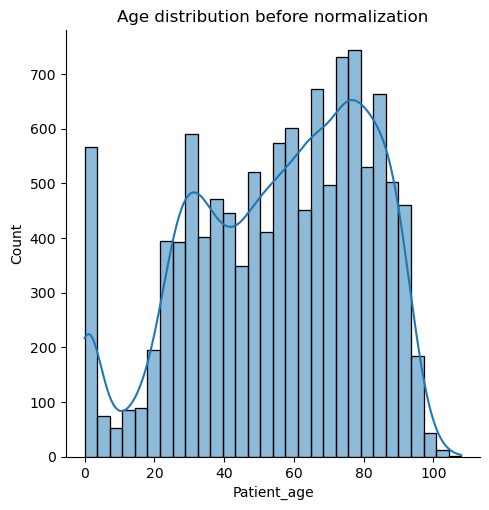

Before scaling (Train): 0.0 108.0 55.77662934791899 25.104485181486513
Before scaling (Test): 0.0 103.0 56.061496924128505 25.2229329150155
After scaling (Train): -2.2218743985541907 2.0803295504695862 -3.9364954145499096e-16 1.0000427341296196
After scaling (Test): -2.2218743985541907 1.8811534417184856 0.011347763067753647 1.004761125860573


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Warning] The 'objective' (='binary') for boosting and the 'likelihood' (='gaussian') for the GPModel do not match. It is assumed that the 'objective' for boosting is correctly specified, and the likelihood of the GPModel is changed accordingly. This can be problematic if the GPModel has been pre-trained 
[GPBoost] [Info] Total Bins 20656
[GPBoost] [Info] Number of data points in the train set: 9360, number of used features: 10199
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.011924
[GPBoost] [Info] Start training from score 2.011924


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20656
[GPBoost] [Info] Number of data points in the train set: 9360, number of used features: 10199
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.011924
[GPBoost] [Info] Start training from score 2.011924


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20656
[GPBoost] [Info] Number of data points in the train set: 9360, number of used features: 10199
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.011924
[GPBoost] [Info] Start training from score 2.011924


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20656
[GPBoost] [Info] Number of data points in the train set: 9360, number of used features: 10199
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.011924
[GPBoost] [Info] Start training from score 2.011924


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20656
[GPBoost] [Info] Number of data points in the train set: 9360, number of used features: 10199
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.011924
[GPBoost] [Info] Start training from score 2.011924
Best AUC for fold: 0.8934 with params {'objective': 'binary', 'n_estimators': 865, 'max_depth': 13, 'num_leaves': 15, 'learning_rate': 0.0273813940290228, 'seed': 42, 'num_threads': 2}


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Warning] The 'objective' (='binary') for boosting and the 'likelihood' (='gaussian') for the GPModel do not match. It is assumed that the 'objective' for boosting is correctly specified, and the likelihood of the GPModel is changed accordingly. This can be problematic if the GPModel has been pre-trained 
[GPBoost] [Info] Total Bins 20662
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10202
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=1.977306
[GPBoost] [Info] Start training from score 1.977306


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20662
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10202
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=1.977306
[GPBoost] [Info] Start training from score 1.977306


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20662
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10202
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=1.977306
[GPBoost] [Info] Start training from score 1.977306


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20662
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10202
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=1.977306
[GPBoost] [Info] Start training from score 1.977306


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20662
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10202
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=1.977306
[GPBoost] [Info] Start training from score 1.977306
Best AUC for fold: 0.9020 with params {'objective': 'binary', 'n_estimators': 1362, 'max_depth': 13, 'num_leaves': 14, 'learning_rate': 0.02088412495387231, 'seed': 42, 'num_threads': 2}


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Warning] The 'objective' (='binary') for boosting and the 'likelihood' (='gaussian') for the GPModel do not match. It is assumed that the 'objective' for boosting is correctly specified, and the likelihood of the GPModel is changed accordingly. This can be problematic if the GPModel has been pre-trained 
[GPBoost] [Info] Total Bins 20677
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10215
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.025054
[GPBoost] [Info] Start training from score 2.025054


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20677
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10215
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.025054
[GPBoost] [Info] Start training from score 2.025054


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20677
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10215
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.025054
[GPBoost] [Info] Start training from score 2.025054


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20677
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10215
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.025054
[GPBoost] [Info] Start training from score 2.025054


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20677
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10215
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.025054
[GPBoost] [Info] Start training from score 2.025054
Best AUC for fold: 0.8928 with params {'objective': 'binary', 'n_estimators': 1122, 'max_depth': 11, 'num_leaves': 38, 'learning_rate': 0.005290113617880868, 'seed': 42, 'num_threads': 2}


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Warning] The 'objective' (='binary') for boosting and the 'likelihood' (='gaussian') for the GPModel do not match. It is assumed that the 'objective' for boosting is correctly specified, and the likelihood of the GPModel is changed accordingly. This can be problematic if the GPModel has been pre-trained 
[GPBoost] [Info] Total Bins 20647
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10197
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=1.958348
[GPBoost] [Info] Start training from score 1.958348


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20647
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10197
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=1.958348
[GPBoost] [Info] Start training from score 1.958348


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20647
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10197
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=1.958348
[GPBoost] [Info] Start training from score 1.958348


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20647
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10197
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=1.958348
[GPBoost] [Info] Start training from score 1.958348


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20647
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10197
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=1.958348
[GPBoost] [Info] Start training from score 1.958348
Best AUC for fold: 0.8935 with params {'objective': 'binary', 'n_estimators': 1737, 'max_depth': 22, 'num_leaves': 38, 'learning_rate': 0.018736855320076344, 'seed': 42, 'num_threads': 2}


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Warning] The 'objective' (='binary') for boosting and the 'likelihood' (='gaussian') for the GPModel do not match. It is assumed that the 'objective' for boosting is correctly specified, and the likelihood of the GPModel is changed accordingly. This can be problematic if the GPModel has been pre-trained 
[GPBoost] [Info] Total Bins 20675
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10212
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=1.997135
[GPBoost] [Info] Start training from score 1.997135


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20675
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10212
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=1.997135
[GPBoost] [Info] Start training from score 1.997135


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20675
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10212
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=1.997135
[GPBoost] [Info] Start training from score 1.997135


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20675
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10212
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=1.997135
[GPBoost] [Info] Start training from score 1.997135


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 20675
[GPBoost] [Info] Number of data points in the train set: 9361, number of used features: 10212
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=1.997135
[GPBoost] [Info] Start training from score 1.997135
Best AUC for fold: 0.8898 with params {'objective': 'binary', 'n_estimators': 733, 'max_depth': 39, 'num_leaves': 25, 'learning_rate': 0.021669127434102622, 'seed': 42, 'num_threads': 2}

Mean CV AUC: 0.894291774733803
Best params overall: {'objective': 'binary', 'n_estimators': 1362, 'max_depth': 13, 'num_leaves': 14, 'learning_rate': 0.02088412495387231, 'seed': 42, 'num_threads': 2}


C:\Users\Guest_PC16\anaconda3\Lib\site-packages\gpboost\engine.py:183: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Warning] The 'objective' (='binary') for boosting and the 'likelihood' (='gaussian') for the GPModel do not match. It is assumed that the 'objective' for boosting is correctly specified, and the likelihood of the GPModel is changed accordingly. This can be problematic if the GPModel has been pre-trained 
[GPBoost] [Info] Total Bins 20783
[GPBoost] [Info] Number of data points in the train set: 11701, number of used features: 10247
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.033425
[GPBoost] [Info] Start training from score 2.033425


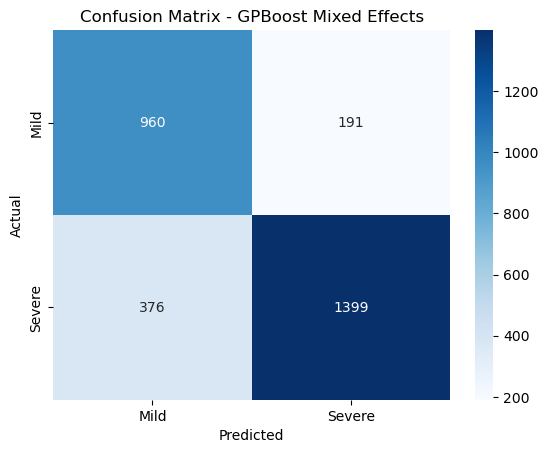


Classification Report:

              precision    recall  f1-score   support

        Mild       0.72      0.83      0.77      1151
      Severe       0.88      0.79      0.83      1775

    accuracy                           0.81      2926
   macro avg       0.80      0.81      0.80      2926
weighted avg       0.82      0.81      0.81      2926

fpr = [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0

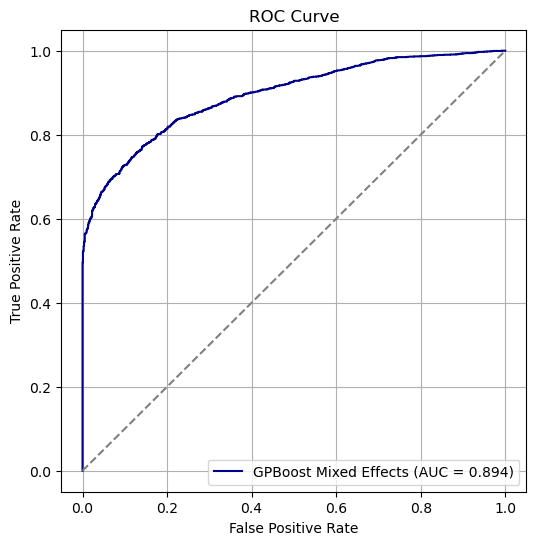

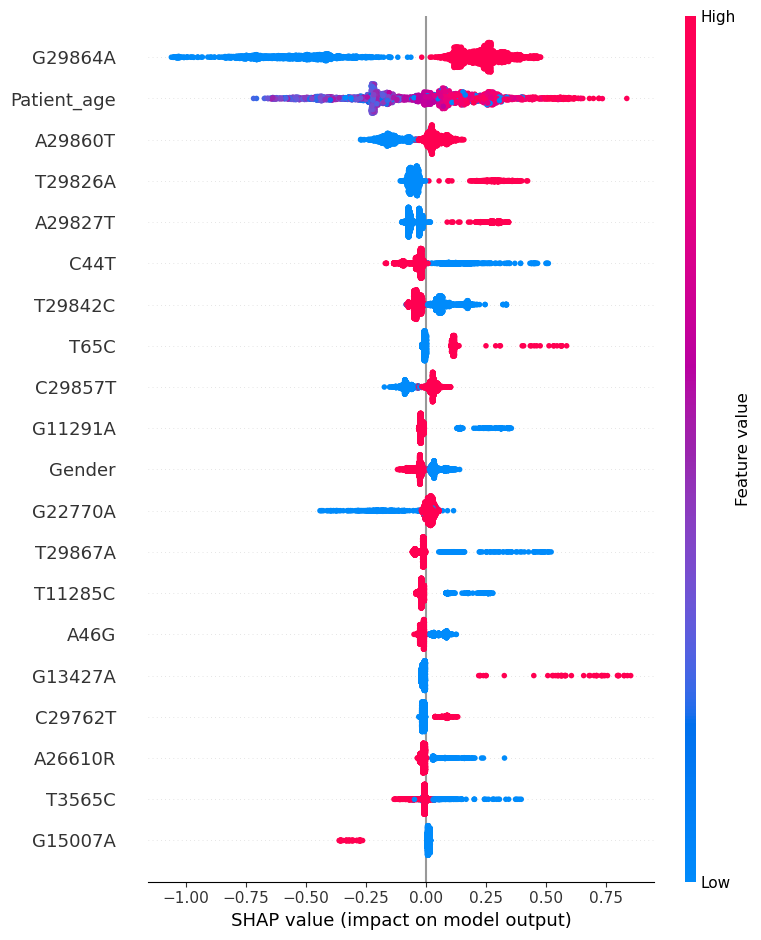

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int32
(11701, 10326)
(11701,)
(2926, 10326)
(2926,)


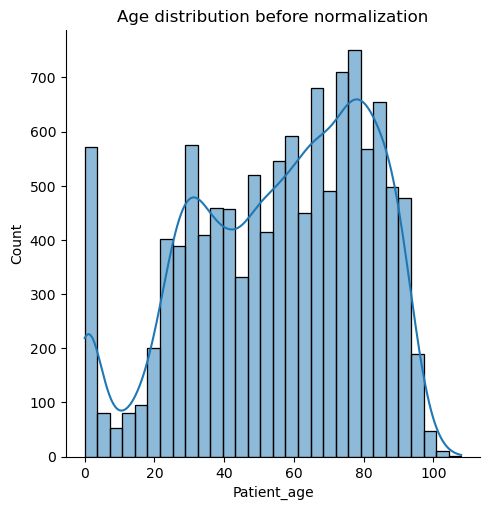

Before scaling (Train): 0.0 108.0 55.830685411503296 25.251047980457482
Before scaling (Test): 0.02 104.0 55.84532809295967 24.63209532737938
After scaling (Train): -2.211118973377338 2.0661140099660873 -2.3925633526149855e-16 1.0000427341296485
After scaling (Test): -2.210326893195237 1.9076979735459605 0.0005799088897203747 0.9755297276215422
Shapes -> (11701, 10326) (2926, 10326) (11701,) (2926,)
CV strategy: KFold(n_splits=5, random_state=42, shuffle=True)
Scorer: make_scorer(accuracy_score, response_method='predict')
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 7095, number of negative: 4606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13151
[LightGBM] [Info] Number of data points in the train set: 11701, number of used 

              precision    recall  f1-score   support

           0       0.73      0.84      0.78      1146
           1       0.89      0.80      0.84      1780

    accuracy                           0.82      2926
   macro avg       0.81      0.82      0.81      2926
weighted avg       0.83      0.82      0.82      2926

Test ROC AUC: 0.8960652097182187
fpr = [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

 99%|===================| 2907/2926 [02:17<00:00]        

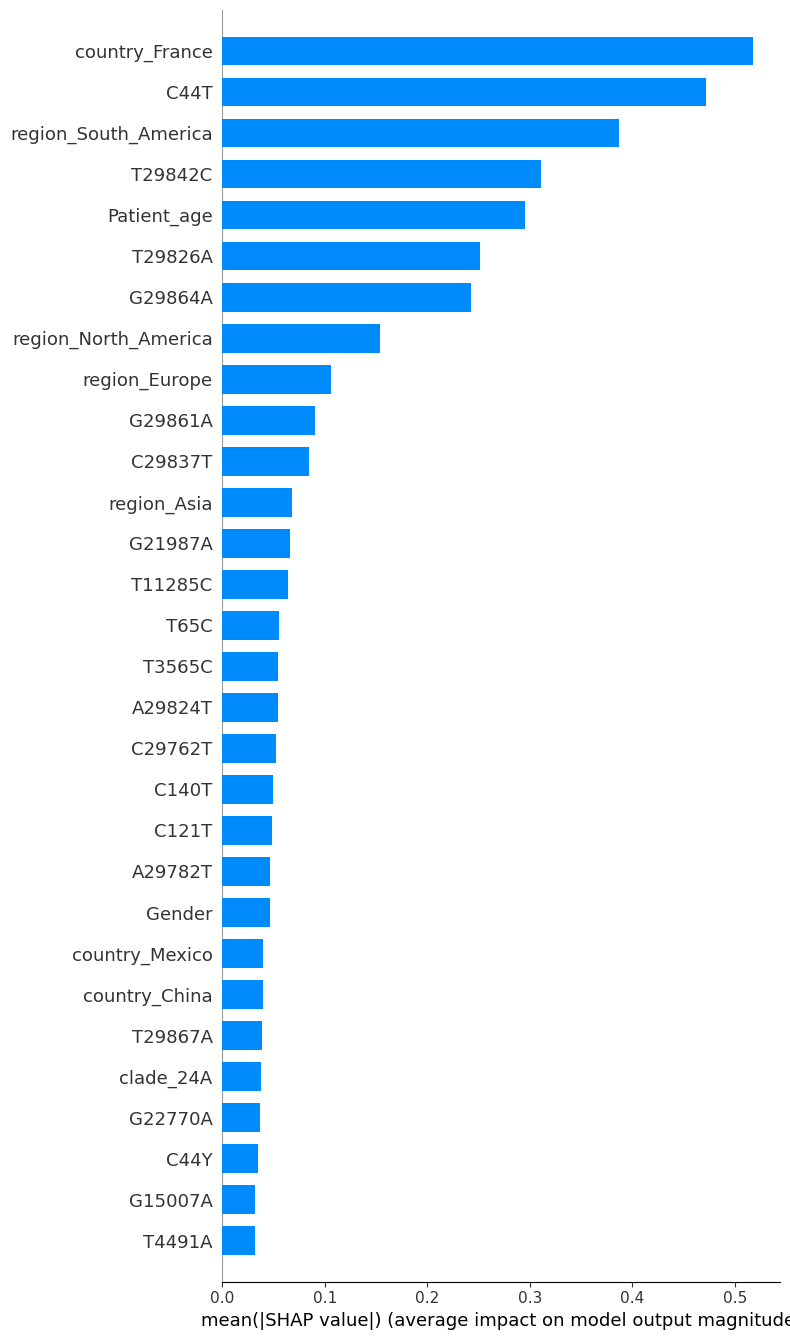

SHAP bar summary saved at shap_summary_plot.tiff


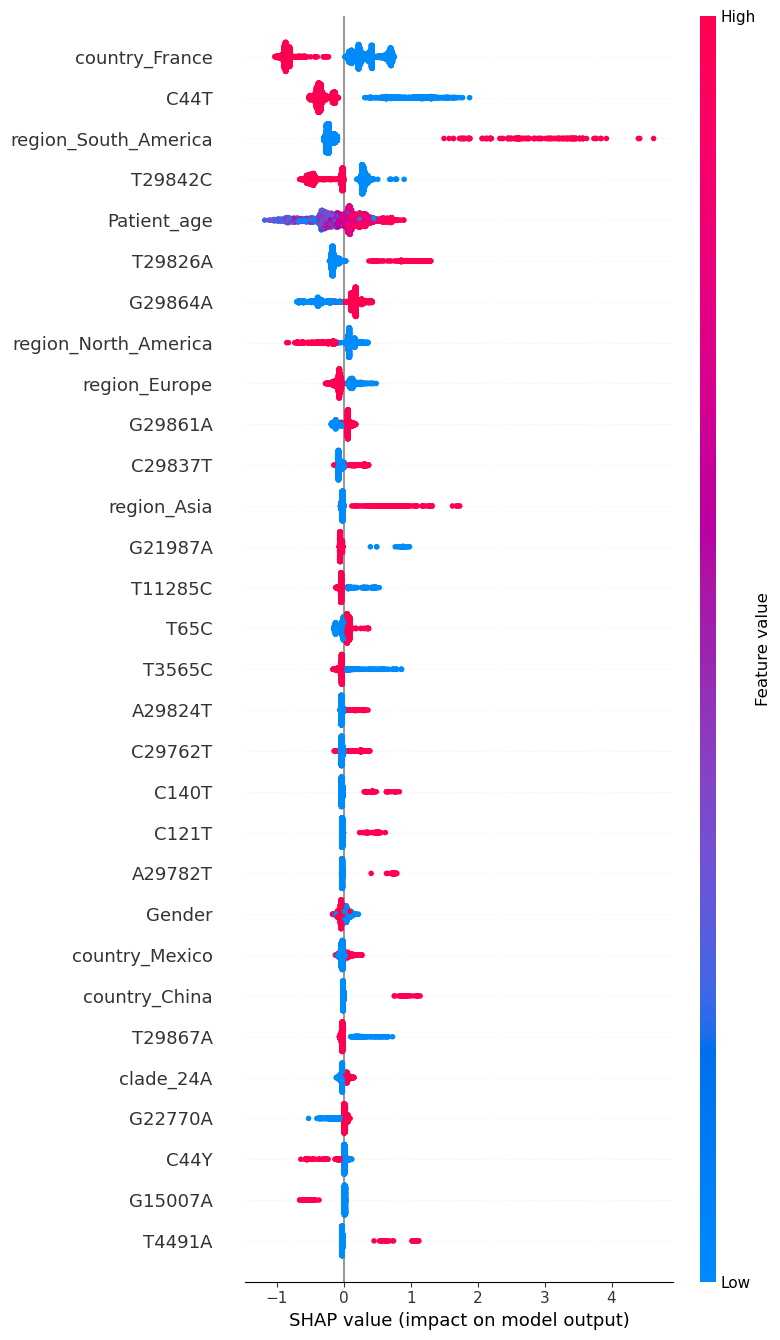

CV strategy for XGBoost: KFold(n_splits=5, random_state=42, shuffle=True)
Scorer for XGBoost: make_scorer(accuracy_score, response_method='predict')
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'gamma': 1.813656883091508, 'learning_rate': 0.0279410926890789, 'max_depth': 36, 'n_estimators': 1132, 'reg_lambda': 2.4540442977674792}
Best score: 0.8119815843181926

 Best Parameters Found for XGBoost: {'gamma': 1.813656883091508, 'learning_rate': 0.0279410926890789, 'max_depth': 36, 'n_estimators': 1132, 'reg_lambda': 2.4540442977674792}

 Test Set Performance:


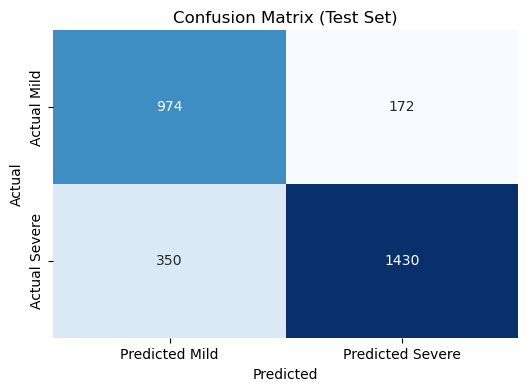

              precision    recall  f1-score   support

           0       0.74      0.85      0.79      1146
           1       0.89      0.80      0.85      1780

    accuracy                           0.82      2926
   macro avg       0.81      0.83      0.82      2926
weighted avg       0.83      0.82      0.82      2926

Test ROC AUC: 0.8990494538894445
fpr = [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

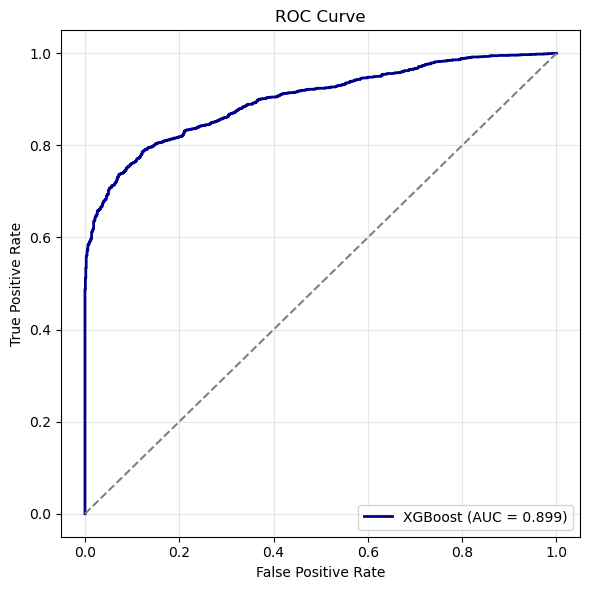

100%|===================| 2913/2926 [02:27<00:00]        

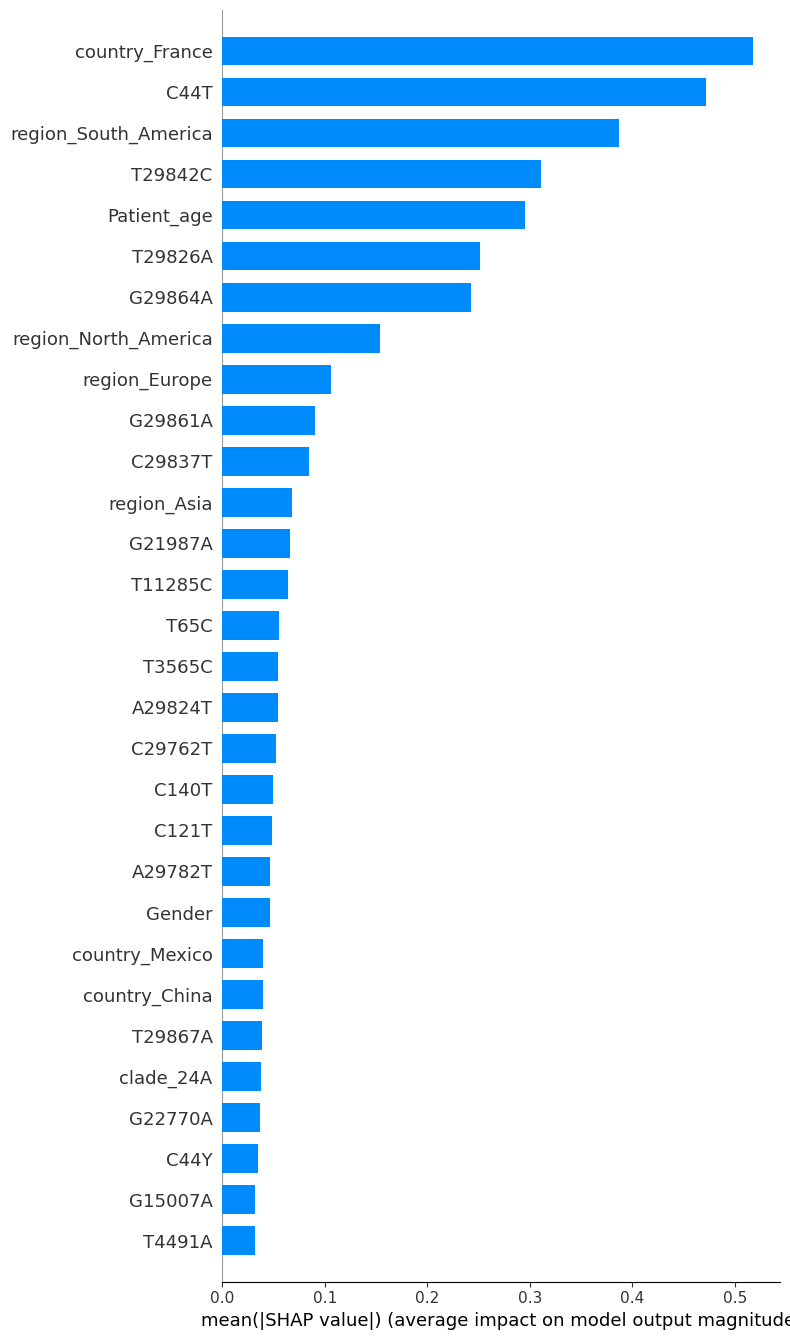

SHAP bar summary saved at shap_summary_plot.tiff


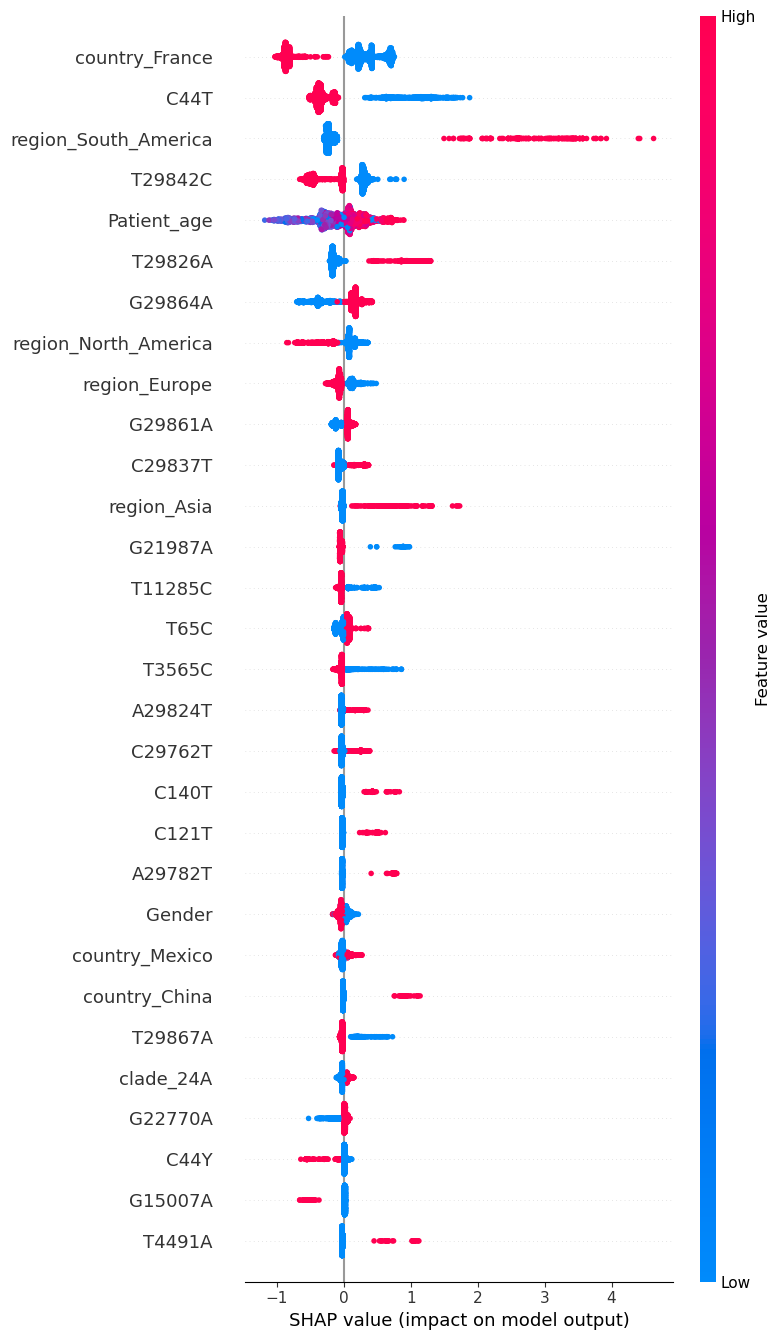

                                        strain  T2G  T3C  A4T  A4C  A5G  A6R  \
0   hCoV-19/Turkey/TSIM_Ankara_140111_978/2024  0.0  0.0  0.0  0.0  0.0  0.0   
1  hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024  1.0  1.0  1.0  0.0  1.0  1.0   
2            hCoV-19/Brazil/RJ-FIOCRUZ-51/2024  1.0  1.0  1.0  0.0  1.0  1.0   
3           hCoV-19/Fujian/FCDC-FZ9970725/2024  1.0  1.0  1.0  0.0  1.0  1.0   
4          hCoV-19/Fujian/FCDC-XM010309HG/2024  1.0  1.0  1.0  0.0  1.0  1.0   

   G7T  G8T  T9C  ...  Nextclade_pango_XFG_9_1  Nextclade_pango_XFJ  \
0  0.0  0.0  0.0  ...                        0                    0   
1  1.0  1.0  1.0  ...                        0                    0   
2  1.0  1.0  1.0  ...                        0                    0   
3  1.0  1.0  1.0  ...                        0                    0   
4  1.0  1.0  1.0  ...                        0                    0   

   Nextclade_pango_XFJ_1  Nextclade_pango_XFJ_2  Nextclade_pango_XFJ_3  \
0                 

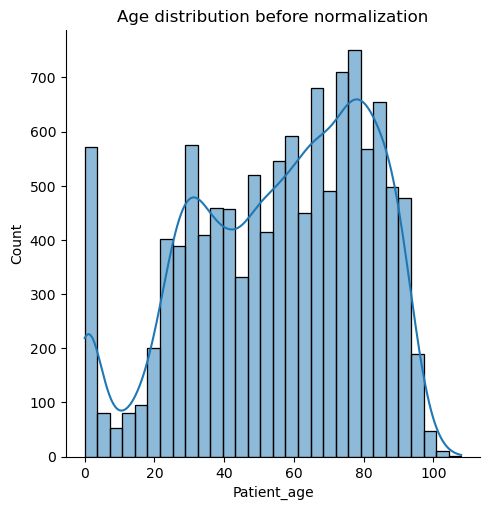

Before scaling (Train): 0.0 108.0 55.830685411503296 25.251047980457482
Before scaling (Test): 0.02 104.0 55.84532809295967 24.63209532737938
After scaling (Train): -2.211118973377338 2.0661140099660873 -2.3925633526149855e-16 1.0000427341296485
After scaling (Test): -2.210326893195237 1.9076979735459605 0.0005799088897203747 0.9755297276215422
CV strategy: KFold(n_splits=5, random_state=42, shuffle=True)
Scorer: make_scorer(accuracy_score, response_method='predict')
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 7095, number of negative: 4606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13109
[LightGBM] [Info] Number of data points in the train set: 11701, number of used features: 6407
[LightGBM] [Info] [binary:BoostFromScore]

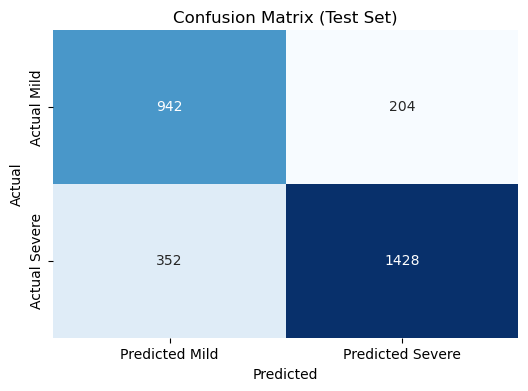

              precision    recall  f1-score   support

           0       0.73      0.82      0.77      1146
           1       0.88      0.80      0.84      1780

    accuracy                           0.81      2926
   macro avg       0.80      0.81      0.80      2926
weighted avg       0.82      0.81      0.81      2926

Test ROC AUC: 0.884740769064847
fpr = [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.72600349e-04
 8.72600349e-04 8.72600349e-04 8.72600349e-04 8.72600349e-04
 1.74520070e-03 1.74520070e-03 1.74520070e-03 1.74520070e-03
 1.74520070e-03 1.74520070e-03 1.74520070e-03 1.74520070e-03
 1.74520070e-03 1.7452007

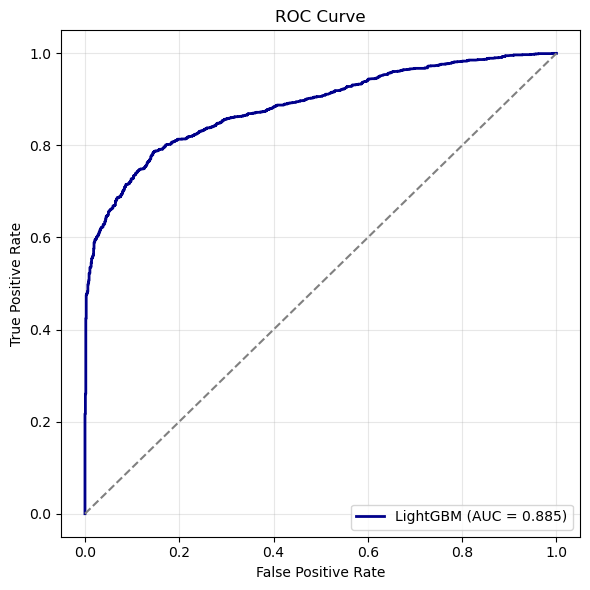

100%|===================| 2914/2926 [02:21<00:00]        

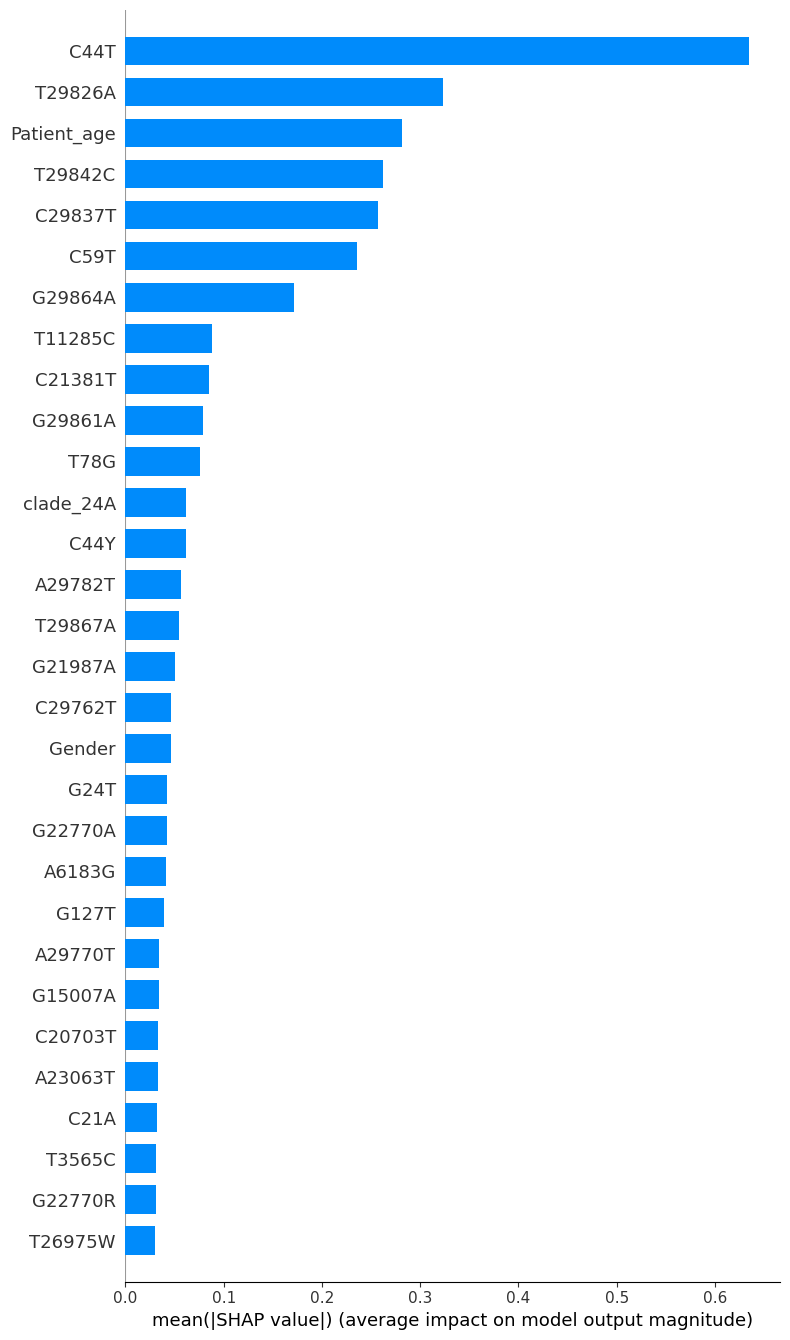

SHAP bar summary saved at shap_summary_plot.tiff


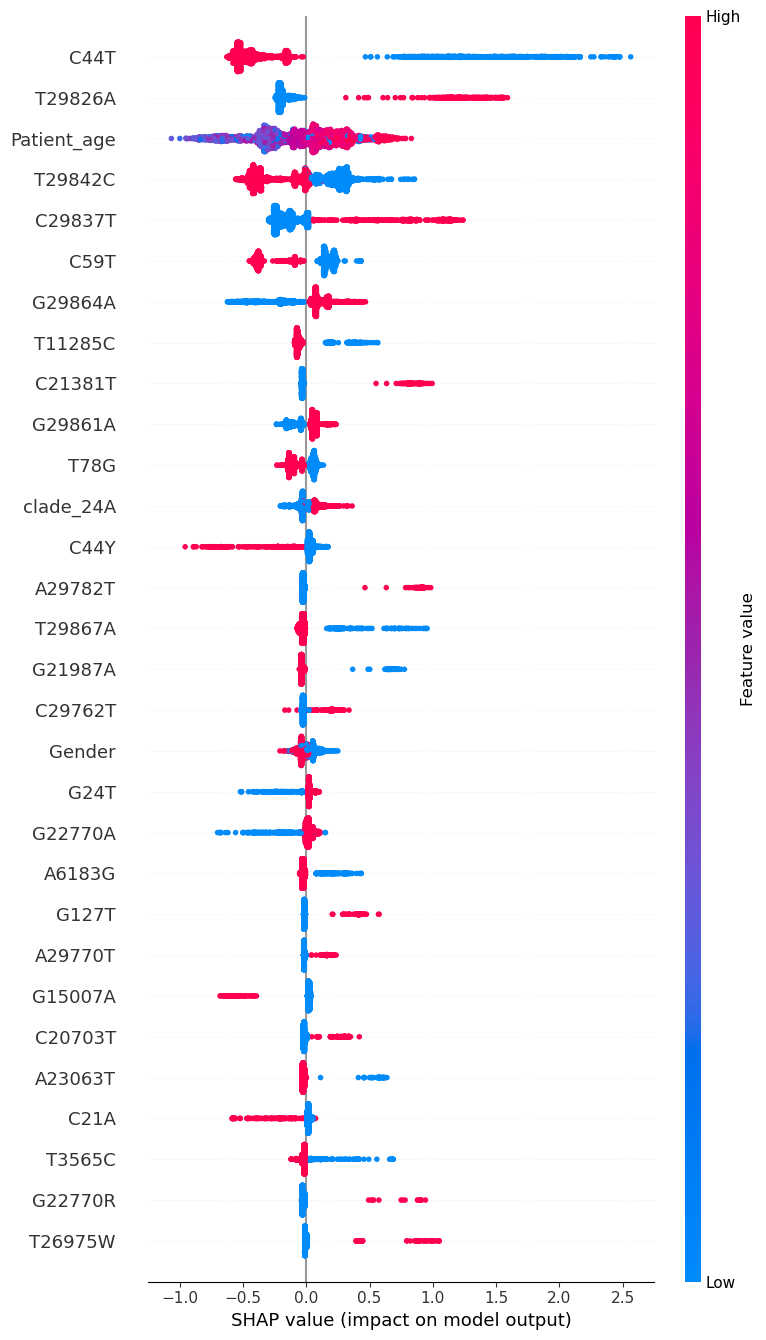

CV strategy for XGBoost: KFold(n_splits=5, random_state=42, shuffle=True)
Scorer for XGBoost: make_scorer(accuracy_score, response_method='predict')
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'gamma': 0.579502905827536, 'learning_rate': 0.01696090743814644, 'max_depth': 11, 'n_estimators': 1181, 'reg_lambda': 2.424361138693251}
Best score: 0.8018115568991263

 Best Parameters Found for XGBoost: {'gamma': 0.579502905827536, 'learning_rate': 0.01696090743814644, 'max_depth': 11, 'n_estimators': 1181, 'reg_lambda': 2.424361138693251}

 Test Set Performance:


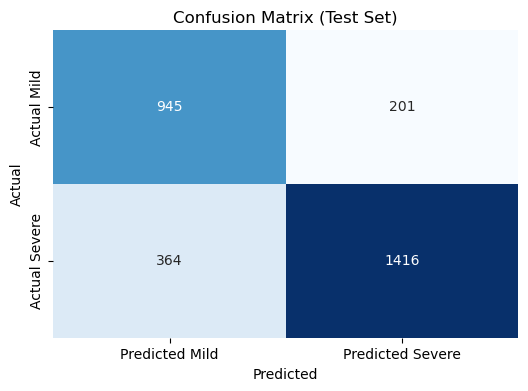

              precision    recall  f1-score   support

           0       0.72      0.82      0.77      1146
           1       0.88      0.80      0.83      1780

    accuracy                           0.81      2926
   macro avg       0.80      0.81      0.80      2926
weighted avg       0.82      0.81      0.81      2926

Test ROC AUC: 0.8876857952428574
fpr = [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

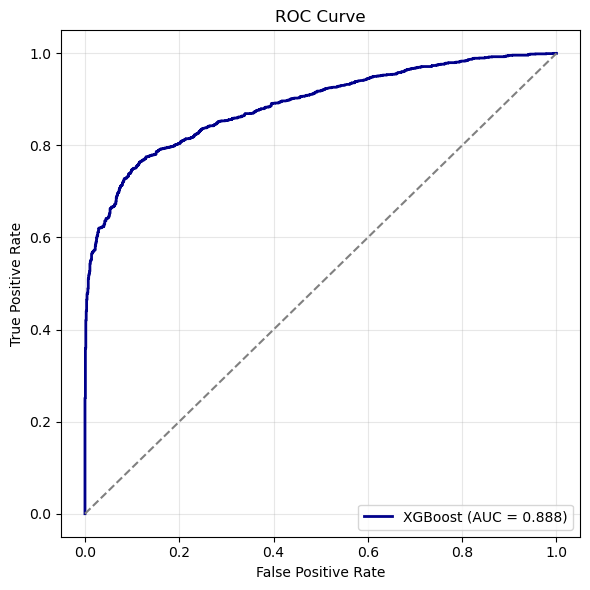

100%|===================| 2915/2926 [02:24<00:00]        

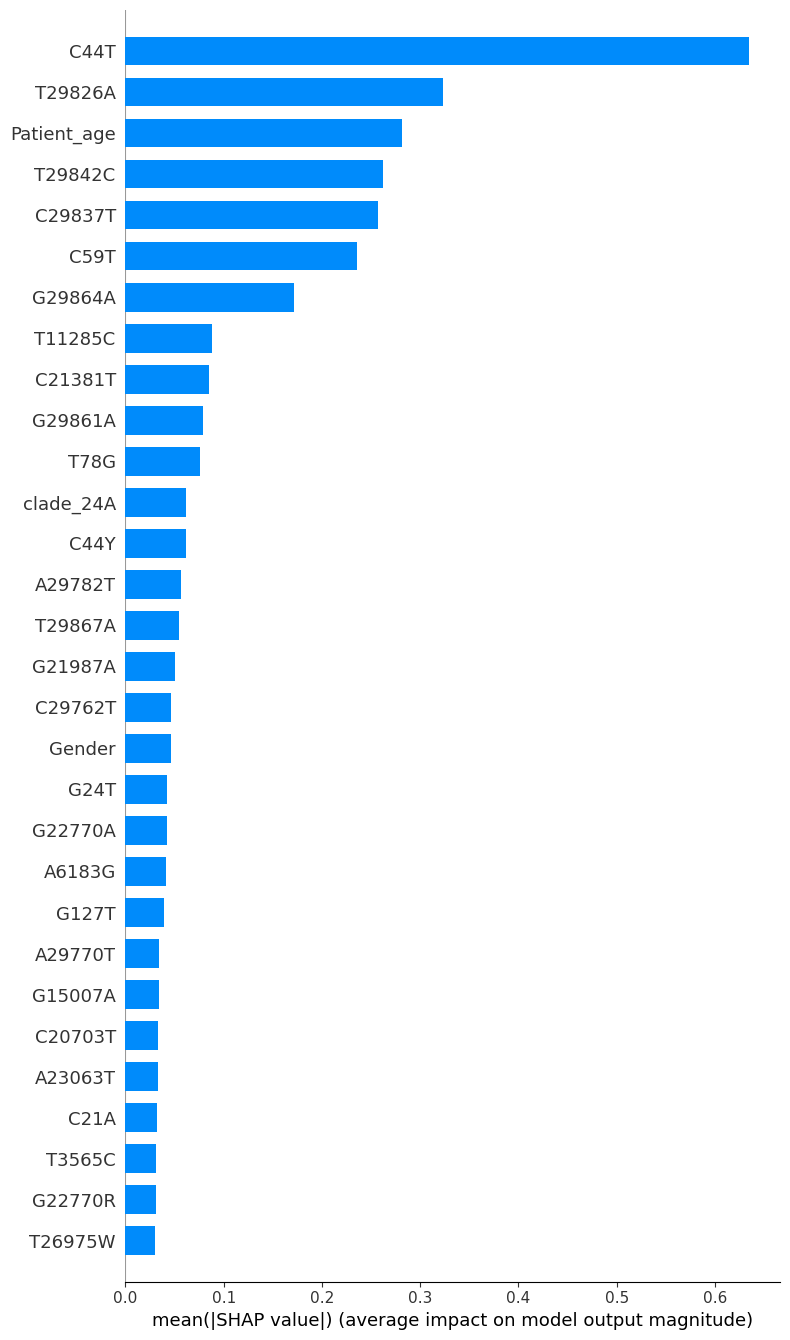

SHAP bar summary saved at shap_summary_plot.tiff


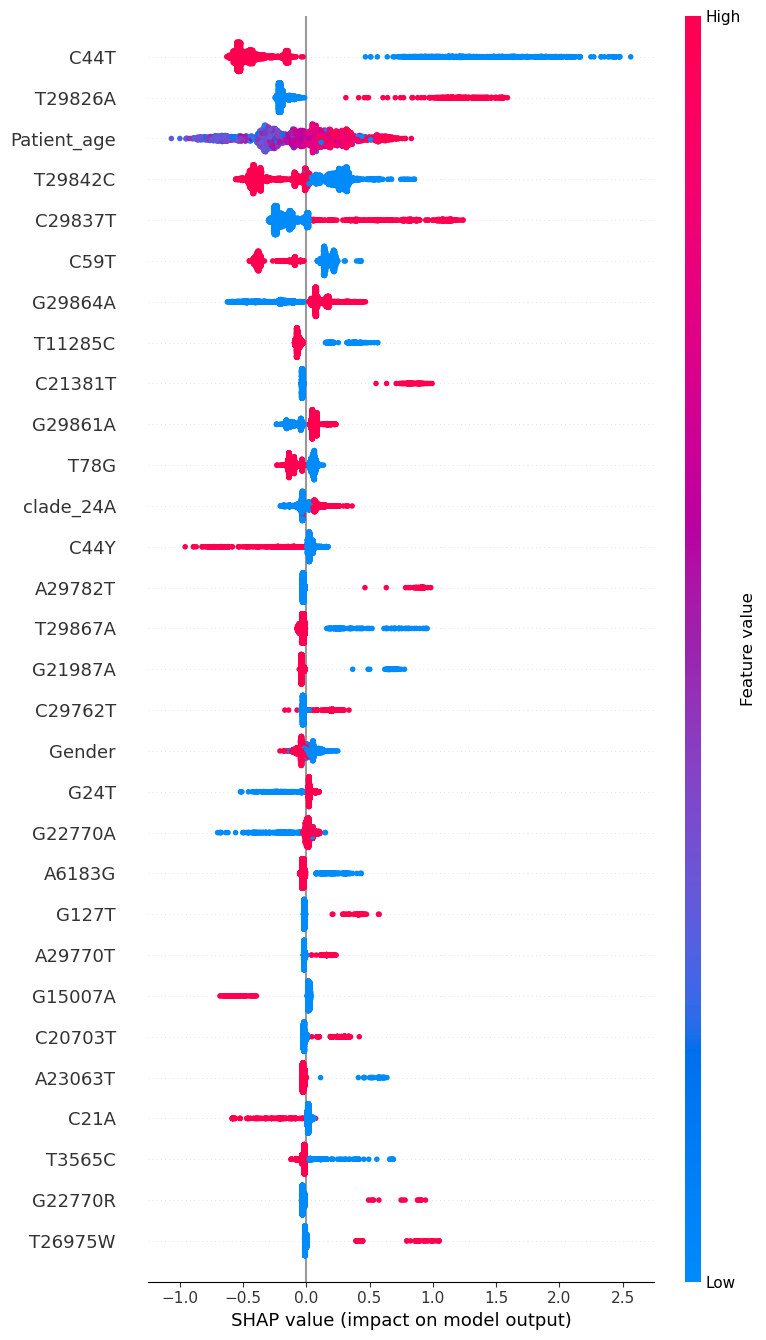


 All preprocessing steps completed. Updated and original files merged successfully. Model training and testing completed successfully!


In [46]:
# Main block
if __name__ == "__main__":
    file_path = input("\n📂 Upload your .tsv file path: ")
    df = validate_tsv(file_path)

    if df is not None:
        print("\n📄 First 5 rows of the file:")
        print(df.head())

        missing = df.isnull().sum()
        if missing.sum() == 0:
            print("\n No missing values found.")
            print(f"Total Rows: {df.shape[0]}, Columns: {df.shape[1]}")
            print(f"Column Names: {list(df.columns)}")
            
           
            if df is None: sys.exit()
            df=concat_with_original(df)
            df=fillmissingvals(df)
            df=dropdate(df)
            df=encodecategory(df)
            df=encodeGender(df)
            df=cladedummies(df)
            df=pangodummies(df)
            df2=df.copy()
            #GPBoost mixed
            df2, le_country, le_region = countryregionlabelencoder(df2)
            print(df2[['country', 'country_encoded']].head())
            print(df2[['region', 'region_encoded']].head())
            group_data = df2[['country_encoded', 'region_encoded']].values
            fixed_effects = df2.drop(columns=['strain','category', 'country_encoded', 'region_encoded', 'country', 'region']) 
            random_effects = df2[['country', 'region']]  # Random effect groups
            target = df2['category']
            X_train, X_test, y_train, y_test, group_train, group_test = split_gpboostmixed_data(fixed_effects, target, group_data, test_size=0.2, stratify=target, random_state=42)
            X_train, X_test = normalizeage(X_train, X_test)
            X_train_np = X_train.values
            X_test_np = X_test.values
            y_train_np = y_train.values
            y_test_np = y_test.values
            group_train_np = group_train
            group_test_np = group_test
            model, preds = cvgpboostmixed(X_train_np, y_train_np, group_train_np,
                              X_test_np, group_test_np,
                              n_iter=5, n_splits=5)
            results = evaluate_model(y_test_np, preds, "GPBoost Mixed Effects")
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test_np)
            shap.summary_plot(shap_values, X_test_np, feature_names=X_test.columns)
            plt.figure()
            shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=30, show=False)
            plt.savefig("shap_summary_plot.tiff", format='tiff', dpi=600, bbox_inches='tight')
            plt.show()
            df=countrydummies(df)
            df=regiondummies(df)
            df=clean_for_lightgbm(df)
            X,y=xydataset(df)
            X_train, X_test, y_train, y_test=split_dataset(X, y, test_size=0.2, random_state=42)
            X_train, X_test = normalizeage(X_train, X_test)
            print("Shapes ->", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
            param_dist = params()
            cv_strategy, scorer = cvfunc()
            print("CV strategy:", cv_strategy)
            print("Scorer:", scorer)
            random_search=modelrandomsearchfit(X_train, y_train)
            best_model = random_search.best_estimator_
            print("Best params:", random_search.best_params_)
            print("Best score:", random_search.best_score_)
            y_pred = best_model.predict(X_test)
            y_prob = best_model.predict_proba(X_test)[:, 1]
            print("\n Best Parameters Found:", random_search.best_params_)
            print("\n Test Set Performance:")
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(6,4))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,xticklabels=["Predicted Mild", "Predicted Severe"],yticklabels=["Actual Mild", "Actual Severe"])
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title("Confusion Matrix (Test Set)")
            plt.show()
            print(classification_report(y_test, y_pred))
            print("Test ROC AUC:", roc_auc_score(y_test, y_prob))
            ruccurve(y_test, y_prob, model_name="LightGBM", save_path="roc_curve_LightGBM.tiff")
            run_shap(best_model, X_train, X_test, max_display=30, save_path="shap_summary_plot.tiff")
            param_distxgcr = paramsxgcr()
            cv_strategy, scorer = cvfunc()
            print("CV strategy for XGBoost:", cv_strategy)
            print("Scorer for XGBoost:", scorer)
            random_searchXGB=modelrandomsearchfitxbcr(X_train, y_train)
            best_modelxgcr = random_searchXGB.best_estimator_
            print("Best params:", random_searchXGB.best_params_)
            print("Best score:", random_searchXGB.best_score_)
            y_pred = best_modelxgcr.predict(X_test)
            y_prob = best_modelxgcr.predict_proba(X_test)[:, 1]
            print("\n Best Parameters Found for XGBoost:", random_searchXGB.best_params_)
            print("\n Test Set Performance:")
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(6,4))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,xticklabels=["Predicted Mild", "Predicted Severe"],yticklabels=["Actual Mild", "Actual Severe"])
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title("Confusion Matrix (Test Set)")
            plt.show()
            print(classification_report(y_test, y_pred))
            print("Test ROC AUC:", roc_auc_score(y_test, y_prob))
            ruccurveXGB(y_test, y_prob, model_name="XGBoost", save_path="roc_curve_XGBoostwithcountryregion.tiff")
            run_shap(best_model, X_train, X_test, max_display=30, save_path="shap_summary_plot.tiff")
            #LightGBM withgout country and region
            df1=regioncountriesdummiesdrop(df)
            print(df1["Patient_age"])
            X,y=xydataset(df1)
            X_train, X_test, y_train, y_test=split_dataset(X, y, test_size=0.2, random_state=42)
            X_train, X_test = normalizeage(X_train, X_test)
            param_dist = params()
            cv_strategy, scorer = cvfunc()
            print("CV strategy:", cv_strategy)
            print("Scorer:", scorer)
            random_search=modelrandomsearchfit(X_train, y_train)
            best_model = random_search.best_estimator_
            print("Best params:", random_search.best_params_)
            print("Best score:", random_search.best_score_)
            y_pred = best_model.predict(X_test)
            y_prob = best_model.predict_proba(X_test)[:, 1]
            print("\n Best Parameters Found:", random_search.best_params_)
            print("\n Test Set Performance:")
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(6,4))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,xticklabels=["Predicted Mild", "Predicted Severe"],yticklabels=["Actual Mild", "Actual Severe"])
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title("Confusion Matrix (Test Set)")
            plt.show()
            print(classification_report(y_test, y_pred))
            print("Test ROC AUC:", roc_auc_score(y_test, y_prob))
            ruccurve(y_test, y_prob, model_name="LightGBM", save_path="roc_curve_LightGBMwithoutcountryregion.tiff")
            run_shap(best_model, X_train, X_test, max_display=30, save_path="shap_summary_plot.tiff")
            #xgboost without country and region
            param_distxgcr = paramsxgcr()
            cv_strategy, scorer = cvfunc()
            print("CV strategy for XGBoost:", cv_strategy)
            print("Scorer for XGBoost:", scorer)
            random_searchXGB=modelrandomsearchfitxbcr(X_train, y_train)
            best_modelxgcr = random_searchXGB.best_estimator_
            print("Best params:", random_searchXGB.best_params_)
            print("Best score:", random_searchXGB.best_score_)
            y_pred = best_modelxgcr.predict(X_test)
            y_prob = best_modelxgcr.predict_proba(X_test)[:, 1]
            print("\n Best Parameters Found for XGBoost:", random_searchXGB.best_params_)
            print("\n Test Set Performance:")
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(6,4))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,xticklabels=["Predicted Mild", "Predicted Severe"],yticklabels=["Actual Mild", "Actual Severe"])
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title("Confusion Matrix (Test Set)")
            plt.show()
            print(classification_report(y_test, y_pred))
            print("Test ROC AUC:", roc_auc_score(y_test, y_prob))
            ruccurveXGB(y_test, y_prob, model_name="XGBoost", save_path="roc_curve_XGBoostwithoutcountryregion.tiff")
            run_shap(best_model, X_train, X_test, max_display=30, save_path="shap_summary_plot.tiff")
            print("\n All preprocessing steps completed. Updated and original files merged successfully. Model training and testing completed successfully!")



In [ ]:
print("Column names in X_train with special chars:")
for col in X_train.columns:
    if any(c in col for c in [' ', '.', '[', ']', '{', '}', '"', "'"]):
        print(repr(col))



In [ ]:
df["A1C"].value_counts()


In [ ]:
X["A1C"].unique.

In [ ]:
 columns=["strain", "Gender", "Month", "Severity_Num", "date", "region","country","Pango_lineage","clade","Patient age", "category"]
for col in df.columns:
    if col not in columns:
        bad_vals = df[~df[col].astype(str).str.strip().str.match(r"^-?\d+$", na=False)][col].unique()
        if len(bad_vals) > 0:
            print(f"Problematic values in {col}: {bad_vals}")


In [ ]:
df.dtypes

In [ ]:
import re

bad_cols = [col for col in df.columns if not re.match(r'^[A-Za-z0-9_]+$', col)]
if bad_cols:
    print("❌ These columns are NOT safe for LightGBM:", bad_cols)
else:
    print("✅ All column names are safe for LightGBM")


In [ ]:
import re

def clean_for_lightgbm(df):
    """
    Cleans DataFrame column names so they are safe for LightGBM.
    - Replaces spaces, slashes, dots, hyphens, etc. with underscores
    - Removes leading/trailing underscores
    - Ensures only [A-Za-z0-9_] remain
    """
    clean_cols = {}
    for col in df.columns:
        new_col = re.sub(r'\W+', '_', str(col))   # replace non-alphanumeric with "_"
        new_col = re.sub(r'_+', '_', new_col)     # collapse multiple "_"
        new_col = new_col.strip('_')              # strip leading/trailing "_"
        clean_cols[col] = new_col
    df = df.rename(columns=clean_cols)
    return df

In [ ]:
df=clean_for_lightgbm(df)

In [ ]:
import re

bad_cols = [col for col in df.columns if not re.match(r'^[A-Za-z0-9_]+$', col)]
if bad_cols:
    print("❌ These columns are NOT safe for LightGBM:", bad_cols)
else:
    print("✅ All column names are safe for LightGBM")

In [ ]:
def drop_low_sum_columns(df, threshold=10):
    """
    Drops numeric columns whose sum is less than threshold.
    """
    numeric_cols = df.select_dtypes(include=['number']).columns
    low_sum_cols = [col for col in numeric_cols if df[col].sum() < threshold]

    if low_sum_cols:
        print(f"⚠️ Dropping columns (sum < {threshold}): {low_sum_cols}")
        df = df.drop(columns=low_sum_cols)
    else:
        print(f"✅ No columns with sum < {threshold} found.")

    return df


In [ ]:
drop_low_sum_columns(df, threshold=10)

In [ ]:
print("Column names in X_train with special chars:")
for col in df.columns:
    if any(c in col for c in [' ', '.', '[', ']', '{', '}', '"', "'"]):
        print(repr(col))